# recurrent neural network (RNN)
- NOTE: virtual env: conda activate py310cuda118

In [1]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
%load_ext autoreload
%autoreload 2
    
torch.manual_seed(1)
    
print(torch.__version__)
print(np.__version__)

2.3.0
1.26.4


In [13]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda" 
elif torch.backends.mps.is_available():
    device = "mps"
print(f"Using {device} device")

Using cuda device


## dataset

In [5]:
df1 = pd.read_csv('/home/yuan/results/epitope/epitope.txt', sep='\t', header=None, index_col=None)
df2 = pd.read_csv('/home/yuan/results/epitope/other.txt', sep='\t', header=None, index_col=None)
df3 = pd.read_csv('/home/yuan/results/epitope/random.txt', sep='\t', header=None, index_col=None)
# df4 = pd.read_csv('/home/yuan/results/epitope/shuffle.txt', sep='\t', header=None, index_col=None)

In [6]:
# drop duplicates
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)

df21 = df2.drop_duplicates()
print(df2.shape, df21.shape)

df31 = df3.drop_duplicates()
print(df3.shape, df31.shape)

(1798795, 2) (1798795, 2)
(1384072, 2) (1384072, 2)
(1797574, 2) (1797574, 2)


In [7]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)
df.head()

(4980441, 2)


,0,1
721545,VGAEYDFSKRTS,epitope
1686523,MTCHRQESCGMVRVWH,random
1302495,RLMWIMIL,epitope
1558660,FEVISHSF,epitope
502163,SRPGIDLVVAAEAGM,other


In [8]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('epitope', 'VGAEYDFSKRTS')
Counter({'epitope': 1798795, 'random': 1797574, 'other': 1384072})


In [9]:
# embedding
from my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
a,b = me.tokenize()
input_vocab, label_vocab = me.build_vocab()

/home/yuan/anaconda3/envs/py310cuda118/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/yuan/anaconda3/envs/py310cuda118/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


example element of data:  ('epitope', 'SKPKTSQPVYRERIA')
split data:  2988264 996088 996089

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: CCELCKYEF ['C', 'C', 'E', 'L', 'C', 'K', 'Y', 'E', 'F']
Vocab-size of input: 23
Vocab-size of labels: 3
OrderedDict([('L', 2888385), ('A', 2507039), ('S', 2457868), ('G', 2284119), ('E', 2280559), ('V', 2251433), ('K', 2066434), ('P', 2054837), ('T', 2008080), ('R', 1954372), ('D', 1891185), ('I', 1810949), ('Q', 1716645), ('N', 1621264), ('F', 1583127), ('Y', 1410379), ('H', 1246531), ('M', 1143709), ('C', 1098817), ('W', 968320), ('X', 149), ('U', 44), ('B', 1)])
counts of input: [1079687, 1078310, 830267]

## Step 3 encoding: encoding each unique token into integers...


In [27]:
from my_collate import MyCollate
from my_rnn import MyRnn
from my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

# Weight for positive class
pos_weight = torch.tensor([2.0]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# loss_fn = nn.BCELoss()

MyRnn(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [28]:
# train RNN model
num_epochs = 10
p = MyProcess(model, collate_fn, num_epochs, loss_fn)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.7779; val_acc: 0.7937, val_recall: 0.7759
Epoch 1 acc: 0.7941; val_acc: 0.7977, val_recall: 0.7871
Epoch 2 acc: 0.7990; val_acc: 0.8012, val_recall: 0.7863
Epoch 3 acc: 0.8021; val_acc: 0.8032, val_recall: 0.7899
Epoch 4 acc: 0.8053; val_acc: 0.8043, val_recall: 0.7923
Epoch 5 acc: 0.8074; val_acc: 0.8027, val_recall: 0.7968
Epoch 6 acc: 0.8090; val_acc: 0.8067, val_recall: 0.7917
Epoch 7 acc: 0.8106; val_acc: 0.8070, val_recall: 0.7928
Epoch 8 acc: 0.8119; val_acc: 0.8078, val_recall: 0.7930
Epoch 9 acc: 0.8128; val_acc: 0.8066, val_recall: 0.7973


In [29]:
stat

,acc_train,loss_train,acc_valid,loss_valid,rec_valid
0,0.777862,0.818257,0.793682,0.809216,0.775855
1,0.794121,0.807352,0.797663,0.805306,0.787062
2,0.798975,0.804211,0.801166,0.803726,0.786269
3,0.802109,0.802203,0.803242,0.802271,0.789901
4,0.805297,0.800278,0.804319,0.801293,0.792253
5,0.807385,0.798907,0.802742,0.801022,0.796751
6,0.808959,0.797842,0.806724,0.800357,0.791673
7,0.810642,0.796874,0.806977,0.799884,0.792763
8,0.811896,0.796077,0.807823,0.799546,0.793015
9,0.812778,0.795482,0.806628,0.799212,0.797332


In [30]:
# test predict
input = [
    # epitope
    'SSPFLKGFLAGYVVAKLRASAV', 
    # other seq
    'AELMPVGDNN',
    # wrong seq
    'AXAXAXAXA',
]
res = p.predict(input)
res

,text,predict
0,SSPFLKGFLAGYVVAKLRASAV,1.000000e+00
1,AELMPVGDNN,1.134174e-14
2,AXAXAXAXA,9.786346e-01


In [31]:
print(trained_model.embedding)
print(trained_model.embedding.weight.shape)

Embedding(27, 48, padding_idx=0)
torch.Size([27, 48])


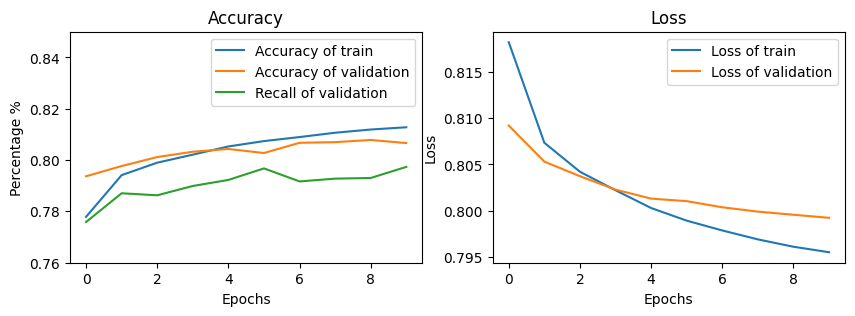

In [32]:
fig = plt.figure(figsize=(10,3))
x_arr = list(range(num_epochs))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, stat.acc_train, label="Accuracy of train")
ax.plot(x_arr, stat.acc_valid, label="Accuracy of validation")
ax.plot(x_arr, stat.rec_valid, label="Recall of validation")
ax.legend(fontsize=10)
ax.set_ylim(.76, .85)
ax.set_title('Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Percentage %')

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, stat.loss_train, label="Loss of train")
ax.plot(x_arr, stat.loss_valid, label="Loss of validation")
ax.legend(fontsize=10)
ax.set_title('Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

plt.show()

In [33]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.7964210731367523,
 'accuracy': 0.8057051126957531,
 'loss': 0.7998656136598065}

In [34]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]
pred_test.head()

,text,predict,labels
0,NLPDFKEELDQWFKNQTLMAPD,1.000000e+00,epitope
1,DHTFDGSQEVNFLQ,9.999999e-01,random
2,TASWFTALTQHGKEDLKFPR,1.000000e+00,epitope
3,WSAIQHTLRNKQYDNQQ,3.425686e-12,random
4,ARQKWKKRH,8.402219e-08,random


359278 636811


Text(0.5, 1.0, 'Distinguish non-epitopes, n = 636811')

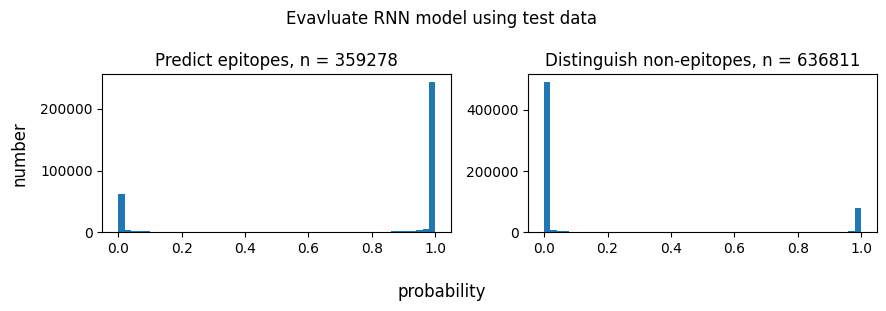

In [35]:
t = pred_test[pred_test['labels']=='epitope']['predict']
f = pred_test[~(pred_test['labels']=='epitope')]['predict']
print(len(t), len(f))

fig, ax = plt.subplots(1, 2, figsize=(9,3), layout='tight')
fig.suptitle('Evavluate RNN model using test data')
fig.supxlabel('probability')
fig.supylabel('number')

ax[0].hist(t, bins=50)
ax[0].set_title(f'Predict epitopes, n = {len(t)}')
ax[1].hist(f, bins=50)
ax[1].set_title(f'Distinguish non-epitopes, n = {len(f)}')

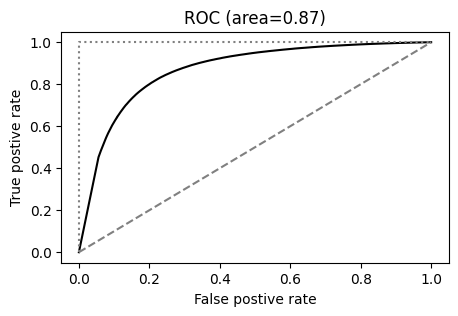

In [36]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(pred_test['labels'], pred_test['predict'], pos_label='epitope')
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,3))
plt.plot(fpr, tpr, color='black')
plt.title(f'ROC (area={roc_auc:.2f})')
plt.xlabel('False postive rate')
plt.ylabel('True postive rate')
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.plot([0,0,1],[0,1,1], linestyle=':', color='grey')

In [37]:
# save model
torch.save(input_vocab, '../models/epitopes_rnn_weighted_vocab.pth')
torch.save(model.state_dict(), '../models/epitopes_rnn_weighted_weights.pth')
torch.save(model, '../models/epitopes_rnn_weighted_model.pth')